# GeoSparse (50/50 PSANN+ReLU) crypto direction test

Loads OHLCV data from the `psann_crypto_trading` Postgres database, builds lagged return features, trains a **mixed-activation GeoSparseRegressor** (50% `psann`, 50% `relu`), and evaluates **direction accuracy** on a chronological holdout split.

This is an experiment (not financial advice).

In [1]:
import os
import sys
import math
import time
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Make local `psann/` importable if running from a source checkout.
root = Path.cwd()
while not (root / "pyproject.toml").exists() and root != root.parent:
    root = root.parent
sys.path.insert(0, str(root / "src"))

from psann import GeoSparseRegressor  # noqa: E402

# Import helpers from your crypto repo.
crypto_repo_env = os.environ.get("PSANN_CRYPTO_REPO", "").strip()
candidates = []
if crypto_repo_env:
    candidates.append(Path(crypto_repo_env))
candidates.extend([Path("/psann_crypto_trading"), Path.home() / "psann_crypto_trading"])
CRYPTO_REPO = next((p for p in candidates if p.exists()), None)
if CRYPTO_REPO is None:
    tried = ", ".join(str(p) for p in candidates)
    raise FileNotFoundError(
        "Crypto repo not found. Set PSANN_CRYPTO_REPO or place it at /psann_crypto_trading or ~/psann_crypto_trading.\n"
        f"Tried: {tried}"
    )
print("CRYPTO_REPO:", CRYPTO_REPO)
sys.path.insert(0, str(CRYPTO_REPO))
try:
    from dotenv import load_dotenv  # type: ignore

    load_dotenv(str(CRYPTO_REPO / ".env"), override=False)
except Exception:
    pass
from database import load_coin_data_with_features  # noqa: E402

print("torch", torch.__version__, "cuda", torch.cuda.is_available())

CRYPTO_REPO: /workspace/psann_crypto_trading
torch 2.10.0a0+b558c986e8.nv25.11 cuda True


In [2]:
# --- Config ---

# Instrument symbols must match what's stored in your Postgres `prices` table.
COINS = ["SOL_USD"]
TARGET_COIN = COINS[0]

# Feature/label construction.
LOOKBACK = 24          # number of lagged return features per coin
TARGET_HORIZON = 3     # predict return over next N bars

# Time window to fetch from DB.
# Pandas versions differ on whether Timestamp.utcnow() is tz-aware.
END = pd.Timestamp.utcnow()
if END.tzinfo is None:
    END = END.tz_localize("UTC")
else:
    END = END.tz_convert("UTC")
START = END - pd.Timedelta(days=180)

# Train/val/test chronological split fractions.
TRAIN_FRAC = 0.70
VAL_FRAC = 0.15

# GeoSparse model.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_K = 4
MODEL_DEPTH = 96
EPOCHS = 200
BATCH_SIZE = 1024
LR = 1e-3

# Speed knobs (optional).
USE_AMP = torch.cuda.is_available()
AMP_DTYPE = "bfloat16"  # bfloat16 recommended on GB10
USE_COMPILE = torch.cuda.is_available()

ACTIVATION_CONFIG = {
    "activation_types": ["psann", "relu"],
    "activation_ratios": [0.25, 0.75],
    "ratio_sum_tol": 1e-3,
    "mix_layout": "random",
}

print({
    "coins": COINS,
    "lookback": LOOKBACK,
    "target_horizon": TARGET_HORIZON,
    "start": str(START),
    "end": str(END),
    "device": DEVICE,
})

{'coins': ['SOL_USD'], 'lookback': 24, 'target_horizon': 3, 'start': '2025-07-22 18:06:58.404116+00:00', 'end': '2026-01-18 18:06:58.404116+00:00', 'device': 'cuda'}


In [3]:
# Load data (requires DB_* env vars or DATABASE_URL; see psann_crypto_trading/database.py)
df = load_coin_data_with_features(
    coins=COINS,
    lookback=LOOKBACK,
    start=START,
    end=END,
    table=None,
    wide=True,
    join_how="inner",
    target_horizon=TARGET_HORIZON,
)
df = df.sort_index()

print("rows", len(df), "cols", df.shape[1])
print("range", df.index.min(), "->", df.index.max())
df.head()

rows 27392 cols 26
range 2025-07-22 20:15:00+00:00 -> 2025-10-25 22:50:00+00:00


,SOL_USD_close,SOL_USD_ret_1,SOL_USD_ret_2,SOL_USD_ret_3,SOL_USD_ret_4,SOL_USD_ret_5,SOL_USD_ret_6,SOL_USD_ret_7,SOL_USD_ret_8,SOL_USD_ret_9,...,SOL_USD_ret_16,SOL_USD_ret_17,SOL_USD_ret_18,SOL_USD_ret_19,SOL_USD_ret_20,SOL_USD_ret_21,SOL_USD_ret_22,SOL_USD_ret_23,SOL_USD_ret_24,SOL_USD_target
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-07-22 20:15:00+00:00,199.72,-0.000750,0.001402,0.003517,0.000553,-0.003207,-0.002300,-0.000350,-0.000549,-0.007585,...,-0.003002,0.007586,0.000000,-0.004786,0.000296,0.002821,0.001040,-0.001484,-0.005217,0.002904
2025-07-22 20:20:00+00:00,200.55,-0.000650,-0.000750,0.001402,0.003517,0.000553,-0.003207,-0.002300,-0.000350,-0.000549,...,-0.002665,-0.003002,0.007586,0.000000,-0.004786,0.000296,0.002821,0.001040,-0.001484,-0.001047
2025-07-22 20:25:00+00:00,200.42,0.004156,-0.000650,-0.000750,0.001402,0.003517,0.000553,-0.003207,-0.002300,-0.000350,...,-0.000495,-0.002665,-0.003002,0.007586,0.000000,-0.004786,0.000296,0.002821,0.001040,0.003044
2025-07-22 20:30:00+00:00,200.30,-0.000648,0.004156,-0.000650,-0.000750,0.001402,0.003517,0.000553,-0.003207,-0.002300,...,0.001436,-0.000495,-0.002665,-0.003002,0.007586,0.000000,-0.004786,0.000296,0.002821,0.003994
2025-07-22 20:35:00+00:00,200.34,-0.000599,-0.000648,0.004156,-0.000650,-0.000750,0.001402,0.003517,0.000553,-0.003207,...,-0.002274,0.001436,-0.000495,-0.002665,-0.003002,0.007586,0.000000,-0.004786,0.000296,0.003344


In [4]:
# Build X/y (predict TARGET_COIN forward return; evaluate direction accuracy)
target_col = f"{TARGET_COIN}_target"
if target_col not in df.columns:
    raise KeyError(f"Missing target column: {target_col}. Available: {list(df.columns)[:10]} ...")

# Drop all *_target columns from features to avoid leakage.
feature_cols = [c for c in df.columns if not c.endswith("_target")]
X = df[feature_cols].to_numpy(dtype=np.float32)
y = df[target_col].to_numpy(dtype=np.float32)
y_dir = (y > 0).astype(np.int32)

pos_rate = float(y_dir.mean())
print("features", X.shape[1], "pos_rate", f"{pos_rate:.3f}")

features 25 pos_rate 0.505


In [5]:
# Chronological split + scale X (fit scaler on train only)
n = len(X)
train_end = int(n * TRAIN_FRAC)
val_end = int(n * (TRAIN_FRAC + VAL_FRAC))

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

y_train_dir = (y_train > 0).astype(np.int32)
y_test_dir = (y_test > 0).astype(np.int32)

x_scaler = StandardScaler().fit(X_train)
X_train = x_scaler.transform(X_train).astype(np.float32, copy=False)

X_val = x_scaler.transform(X_val).astype(np.float32, copy=False)
X_test = x_scaler.transform(X_test).astype(np.float32, copy=False)

print("train/val/test", len(X_train), len(X_val), len(X_test))

train/val/test 19174 4109 4109


In [6]:
def _square_shape(n_features: int) -> tuple[int, int]:
    side = int(math.ceil(math.sqrt(int(n_features)))) * 2
    return side, side


def _pad_to_shape(X_2d: np.ndarray, shape: tuple[int, int]) -> np.ndarray:
    h, w = shape
    f = int(X_2d.shape[1])
    f2 = int(h) * int(w)
    if f2 < f:
        raise ValueError(f"shape {shape} too small for features={f}")
    if f2 == f:
        return X_2d.reshape(-1, h, w)
    out = np.zeros((X_2d.shape[0], f2), dtype=X_2d.dtype)
    out[:, :f] = X_2d
    return out.reshape(-1, h, w)


SHAPE = _square_shape(X_train.shape[1])
X_train_g = _pad_to_shape(X_train, SHAPE)
X_val_g = _pad_to_shape(X_val, SHAPE)
X_test_g = _pad_to_shape(X_test, SHAPE)

print("shape", SHAPE, "input_dim", SHAPE[0] * SHAPE[1])

shape (10, 10) input_dim 100


In [7]:
# Train mixed-activation GeoSparse
seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)

model = GeoSparseRegressor(
    shape=SHAPE,
    hidden_layers=MODEL_DEPTH,
    k=MODEL_K,
    activation_type="mixed",
    activation=ACTIVATION_CONFIG,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    early_stopping=True,
    patience=20,
    device=DEVICE,
    amp=USE_AMP,
    amp_dtype=AMP_DTYPE,
    compile=USE_COMPILE,
    compile_backend="inductor",
    compile_mode="default",
)

t0 = time.perf_counter()
model.fit(X_train_g, y_train, validation_data=(X_val_g, y_val), verbose=1)
train_s = time.perf_counter() - t0
print(f"train_time_s={train_s:.2f}")

/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/Context.cpp:45.)
  return torch._C._get_cublas_allow_tf32()
W0118 18:07:42.334000 4839 torch/_inductor/utils.py:1580] [0/0] Not enough SMs to use max_autotune_gemm mode


Epoch 1/200 - loss: 0.088801 - val_loss: 0.139417
Epoch 2/200 - loss: 0.027214 - val_loss: 0.062485
Epoch 3/200 - loss: 0.007632 - val_loss: 0.045500
Epoch 4/200 - loss: 0.004605 - val_loss: 0.037809
Epoch 5/200 - loss: 0.003267 - val_loss: 0.031728
Epoch 6/200 - loss: 0.002324 - val_loss: 0.026928
Epoch 7/200 - loss: 0.001595 - val_loss: 0.023066
Epoch 8/200 - loss: 0.001117 - val_loss: 0.020248
Epoch 9/200 - loss: 0.000847 - val_loss: 0.018073
Epoch 10/200 - loss: 0.000694 - val_loss: 0.016460
Epoch 11/200 - loss: 0.000594 - val_loss: 0.015273
Epoch 12/200 - loss: 0.000511 - val_loss: 0.014186
Epoch 13/200 - loss: 0.000450 - val_loss: 0.013207
Epoch 14/200 - loss: 0.000389 - val_loss: 0.012371
Epoch 15/200 - loss: 0.000344 - val_loss: 0.011592
Epoch 16/200 - loss: 0.000308 - val_loss: 0.010864
Epoch 17/200 - loss: 0.000280 - val_loss: 0.010242
Epoch 18/200 - loss: 0.000246 - val_loss: 0.009581
Epoch 19/200 - loss: 0.000225 - val_loss: 0.009115
Epoch 20/200 - loss: 0.000206 - val_loss

In [8]:
def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float((y_true == y_pred).mean())


def balanced_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    # mean recall across classes
    out = []
    for cls in (0, 1):
        mask = y_true == cls
        if mask.sum() == 0:
            continue
        out.append(float((y_pred[mask] == cls).mean()))
    return float(sum(out) / max(len(out), 1))


def wilson_ci(successes: int, n: int, z: float = 1.96) -> tuple[float, float]:
    if n <= 0:
        return (0.0, 1.0)
    phat = successes / n
    denom = 1.0 + (z * z) / n
    centre = (phat + (z * z) / (2.0 * n)) / denom
    margin = (z * math.sqrt((phat * (1 - phat) + (z * z) / (4.0 * n)) / n)) / denom
    return float(centre - margin), float(centre + margin)


# Predict returns -> direction
pred = np.asarray(model.predict(X_test_g), dtype=np.float32).reshape(-1)
pred_dir = (pred > 0).astype(np.int32)

acc = accuracy(y_test_dir, pred_dir)
bacc = balanced_accuracy(y_test_dir, pred_dir)

# Baselines
maj = int((y_test_dir.mean() >= 0.5))
acc_majority = accuracy(y_test_dir, np.full_like(y_test_dir, maj))
acc_always_up = accuracy(y_test_dir, np.ones_like(y_test_dir))

n_test = int(len(y_test_dir))
correct = int((y_test_dir == pred_dir).sum())
ci_lo, ci_hi = wilson_ci(correct, n_test)

print({
    "n_test": n_test,
    "acc": round(acc, 4),
    "acc_ci95": (round(ci_lo, 4), round(ci_hi, 4)),
    "balanced_acc": round(bacc, 4),
    "acc_majority": round(acc_majority, 4),
    "acc_always_up": round(acc_always_up, 4),
})

{'n_test': 4109, 'acc': 0.5001, 'acc_ci95': (0.4848, 0.5154), 'balanced_acc': 0.4981, 'acc_majority': 0.506, 'acc_always_up': 0.506}


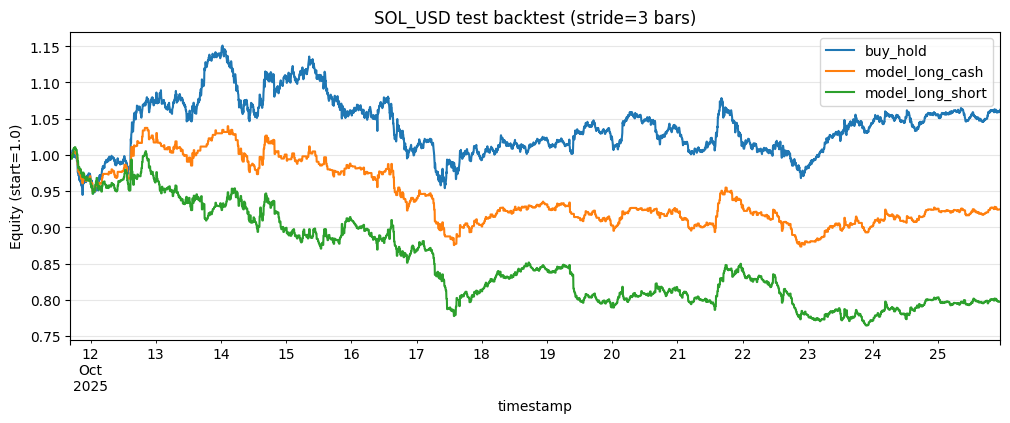

In [9]:
# --- Backtest on the test split (non-overlapping trades) ---

# Install matplotlib if missing (works in venv/Colab).
try:
    import matplotlib.pyplot as plt
except Exception:
    import sys
    import subprocess

    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "matplotlib"])
    import matplotlib.pyplot as plt


# Ensure predictions exist.
if "pred" not in globals():
    pred = np.asarray(model.predict(X_test_g), dtype=np.float32).reshape(-1)

idx = df.index
idx_test = idx[val_end:]

close_col = f"{TARGET_COIN}_close"
if close_col not in df.columns:
    raise KeyError(f"Missing close column {close_col}. Available: {list(df.columns)[:10]} ...")
close_test = df[close_col].to_numpy(dtype=np.float32)[val_end:]

# Use non-overlapping trades based on the label horizon.
stride = max(int(TARGET_HORIZON), 1)
entry_ix = np.arange(0, len(y_test), stride, dtype=np.int64)
exit_ix = entry_ix + stride
# Keep only trades whose exit timestamp exists in df.
valid = exit_ix < len(idx_test)
entry_ix = entry_ix[valid]
exit_ix = exit_ix[valid]

if len(entry_ix) < 2:
    raise RuntimeError(
        f"Not enough test samples for a stride={stride} backtest. "
        f"Have n_test={len(y_test)}; need at least {2 * stride}."
    )

r = y_test[entry_ix].astype(np.float32)
pred_r = pred[entry_ix].astype(np.float32)

if np.any(r <= -1.0):
    raise ValueError("Found a return <= -100%; cannot compound. Check data/labels.")

# Two simple strategies:
# - long/cash: go long only when prediction is positive
# - long/short: go long when positive, short otherwise
pos_long_cash = (pred_r > 0).astype(np.float32)
pos_long_short = np.where(pred_r > 0, 1.0, -1.0).astype(np.float32)


def equity_from_trades(returns: np.ndarray, positions: np.ndarray, start: float = 1.0) -> np.ndarray:
    eq = np.empty(int(len(returns)) + 1, dtype=np.float64)
    eq[0] = float(start)
    for i, (ret, pos) in enumerate(zip(returns, positions), start=1):
        eq[i] = eq[i - 1] * (1.0 + float(pos) * float(ret))
    return eq


eq_long_cash = equity_from_trades(r, pos_long_cash)
eq_long_short = equity_from_trades(r, pos_long_short)

# Stepwise equity series: updated on each trade exit, held constant between exits.
t0 = idx_test[int(entry_ix[0])]
times = [t0] + list(idx_test[exit_ix])
bt_step = pd.DataFrame(
    {
        "model_long_cash": eq_long_cash,
        "model_long_short": eq_long_short,
    },
    index=pd.DatetimeIndex(times),
)

# Buy & hold equity across the full test period.
bt_plot = pd.DataFrame(
    {"buy_hold": close_test / float(close_test[0])},
    index=pd.DatetimeIndex(idx_test),
)
bt_plot = bt_plot.join(bt_step.reindex(bt_plot.index, method="ffill"))


def max_drawdown(eq: np.ndarray) -> float:
    peak = np.maximum.accumulate(eq)
    dd = (eq / peak) - 1.0
    return float(dd.min())


summary = {
    "n_test": int(len(y_test)),
    "n_trades": int(len(r)),
    "stride_bars": int(stride),
    "final_buy_hold": float(bt_plot["buy_hold"].iloc[-1]),
    "final_model_long_cash": float(bt_plot["model_long_cash"].iloc[-1]),
    "final_model_long_short": float(bt_plot["model_long_short"].iloc[-1]),
    "mdd_buy_hold": max_drawdown(bt_plot["buy_hold"].to_numpy()),
    "mdd_model_long_cash": max_drawdown(bt_plot["model_long_cash"].to_numpy()),
    "mdd_model_long_short": max_drawdown(bt_plot["model_long_short"].to_numpy()),
    "hit_rate_long_cash": float((pos_long_cash * r > 0).mean()),
    "hit_rate_long_short": float((pos_long_short * r > 0).mean()),
}
pd.Series(summary).to_frame("value")

ax = bt_plot.plot(figsize=(12, 4), title=f"{TARGET_COIN} test backtest (stride={stride} bars)")
ax.set_ylabel("Equity (start=1.0)")
ax.grid(True, alpha=0.3)
plt.show()
